Goal is to do telluric correction on the target spectrum

In [1]:
import astropy.units as u
import numpy as np
from numpy import random
from math import *
from astropy.io import fits,ascii
import sys
from scipy import signal,integrate,interpolate
from scipy.optimize import curve_fit

from specutils import Spectrum1D
from specutils import SpectralRegion
from specutils.fitting import estimate_line_parameters,fit_lines
from astropy.modeling import models
from specutils.manipulation import (box_smooth, gaussian_smooth, trapezoid_smooth,extract_region,FluxConservingResampler)

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('font',family='serif')
from matplotlib.ticker import AutoMinorLocator

In [2]:
# define constants (all cgs)
h=6.626e-27
k=1.381e-16
c=2.99792e10

The following are different functions

In [3]:
### Load coadded spectrum from PypeIt ###
def LoadPyPeit(filename):
    f=fits.open(filename)
    tbdata=f[1].data
    wv=tbdata['wave']
    flux=tbdata['flux']
    eflux=np.sqrt(tbdata['ivar'])
    spec=Spectrum1D(spectral_axis=wv*u.AA,flux=flux*u.ct)
    return spec

In [4]:
### Load telluric spectrum from previous step ###
def LoadFile(filename):
    data=ascii.read(filename) 
    return data['wavelength'],data['flux']

In [5]:
### Save calibrated target spectrum ###
def SaveOutput(wv,flux,outname):
    data_out={'wavelength': wv,'flux': flux}
    ascii.write(data_out,outname, overwrite = True)

In [6]:
### Convert photometry points from magnitude to flux ###
def FluxCal(Mag,unMag,F0):
    flux=F0*10**(-0.4*Mag)
    unflux = flux*0.4*log(10)*unMag
    return flux,unflux

In [7]:
### Apply telluric correction to target spectrum ###
def ApplyCorr(wv_tar,flux_tar,wv_tell,flux_tell,plotflag):
    # Applying telluric correction (target/telluric):
    flux_tar_inp=np.interp(wv_tell,wv_tar,flux_tar)
    flux_tar_corr=np.array([x/y for x,y in zip(flux_tar_inp,flux_tell)])
    if plotflag=='Y':
        plt.figure(figsize = (15,5))
        plt.step(wv_tar,flux_tar, label = 'Raw Target')
        plt.step(wv_tell,flux_tar_corr, label = 'Telluric Corrected')
        plt.title('Target Correction')
        plt.legend()
        plt.show()
        plt.close('all')
    return wv_tell,flux_tar_corr

In [28]:
### Remove section of spectrum between wv1 and wv2 ###
def CutNoise(wvspec,fspec,wv1,wv2,Plot):
    ind = np.where((wvspec<wv1) | (wvspec>wv2))[0]
    wv_new,f_new = wvspec[ind],fspec[ind]
    if Plot==True:
        %matplotlib inline
        plt.figure(figsize=(10,5))
        plt.title(target,fontsize=15)
        plt.plot(wv_new,f_new,label='New spectrum',zorder=1)
        bottom,top = plt.ylim()
        plt.ylim(bottom,top)
        plt.plot(wvspec,fspec,label='Edges Cut',zorder=0)
        plt.xlabel('Angstroms',fontsize=15)
        plt.ylabel('Flux',fontsize=15)
        plt.legend(fontsize=12)
        plt.show()
    return wv_new,f_new

In [13]:
### Blackbody equation for plotting WD model flux ###

# wv  = Wavelength array to calculate BB model
# T   = WD Teff
# R   = WD radius (Rsun)
# par = WD parallax (mas)
def BBFormula(wv,T,R,par):
    R = R * u.R_sun
    d = 1000/par * u.parsec
    Rd = R.to(u.parsec)/d
    nu=c/wv*1e8
    return (2*h*nu**3)/((c**2)*(np.exp(h*nu/k/T)-1))*np.pi*(Rd)**2*1e29

### Equation used to fit a scaling factor to the BB model
def ScalingFit(wv,sc):
    return BBFormula(wv,T,R,par) * sc

In [16]:
### Converts vacuum wavelengths to air ### 
# Uses Morton (2000) equation for conversion
def Vacuum_to_Air(wv_vac):
    s = (10**4)/wv_vac
    n = 1 + 0.0000834254 + 0.02406147/(130-s**2) + 0.00015998/(38.9-s**2)
    wv_air = wv_vac/n
    return wv_air

In [10]:
### Perform the flux calibration of spectrum using photometry ###
# I am using NIRI JHK photometry+transmission curves to do this, this can be changed by swapping transmission curves

# wv_tar     = Target spectrum wavelength axis
# flux_tar   = Telluric corrected target flux
# wv_trans   = Transmission curve wavelength axis (Must be same units as wv_tar!)
# flux_trans = Transmission curve throughput axis (Must be a fraction!)
# phot_value = Photometric flux value that will be used to calibrate spectrum
# plots      = "True" plots the target's corrected flux, NIRI transmission curve, and the convolved spectrum

### Returns calibration ratio to multiply target spectrum by to calibrate to flux ###
def SpecCal(wv_tar,flux_tar,wv_trans,flux_trans,phot_value,plots):
# Interpolating the transmission filter to the target's wavelength axis:
    trans_filter = np.interp(wv_tar,wv_trans,flux_trans)
# Element-wise multiplying target flux by transmission filter to get "convolved" target spectra to photometry filter:
    convolved_spectra = trans_filter*flux_tar
    if plots == True:
        plt.figure(figsize = (15,3))
        plt.subplot(1,3,1)
        plt.title('Corrected Spectrum')
        plt.plot(wv_tar,flux_tar)
        plt.subplot(1,3,2)
        plt.title('Transmission Curve')
        plt.plot(wv_tar,trans_filter)
        plt.subplot(1,3,3)
        plt.title('Convolved" Spectrum')
        plt.plot(wv_tar,convolved_spectra)
# Simulated photometry point if target spectrum was observed in photometry filter 
    target_flux = integrate.simps(convolved_spectra) / integrate.simps(trans_filter)
# Ratio between the catalog photometric flux and target_flux (calibration ratio)
    ratio = phot_value/target_flux
    return ratio

Calling the functions

In [38]:
target   = 'GaiaJ0006+2858_example'       ## Name of target
telluric = 'HIP1123'                      ## Name of telluric correction star
T        = 20989                          ## WD T_eff and uncertainty (K)
R        = 0.0155                         ## WD radius (Rsun)
par      = 6.3887                         ## Parallax (mas)

# Photometry of this object with uncertainty that will be used for flux calibration
Mag_JHK=np.array([16.8,16.76,16.13])
unMag_JHK=np.array([0.06,0.05,0.08])

# Optical photometry to anchor WD blackbody model (not required for calibration, just for plotting the model)
Mag_opt = np.array([16.1838,16.5537,16.8784,17.0686,17.2857])  # I'm using PanSTARRS
unMag_opt = np.array([0.003,0.004,0.0033,0.0044,0.0074])

Doing telluric correction

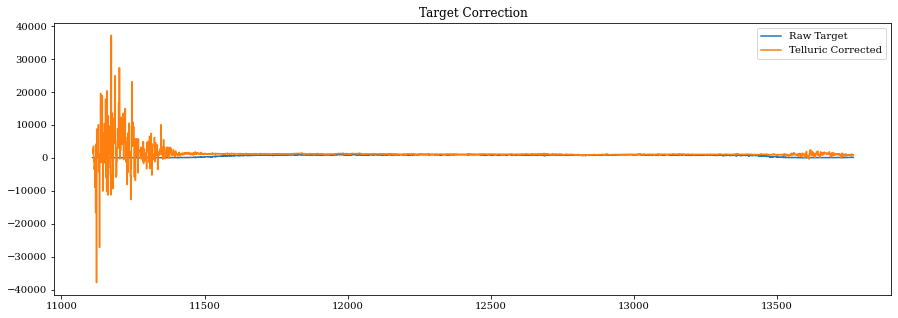

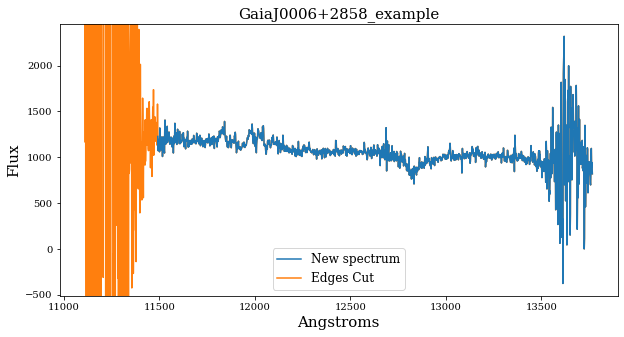

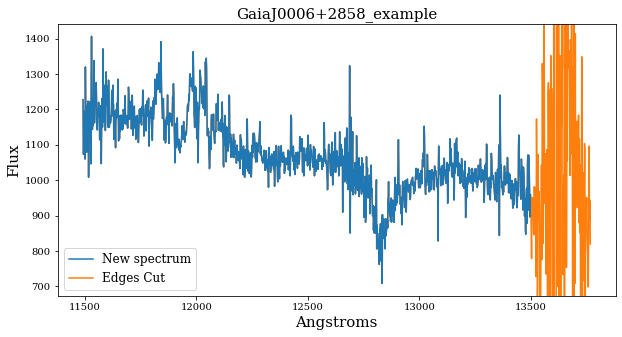

In [35]:
# Loading raw target spectrum and telluric spectrum from previous step:
spec_tar=LoadPyPeit('exampletarget-coadd.fits')
wv_tell,flux_tell=LoadFile('telluric-step2.txt')

# Applying telluric correction to target spectrum:
wv_corr,flux_corr=ApplyCorr(spec_tar.spectral_axis,spec_tar.flux,wv_tell,flux_tell,'Y')

# Removing regions of high-noise by hand:
wv_corr,flux_corr=CutNoise(wv_corr,flux_corr,11000,11490,True)
wv_corr,flux_corr=CutNoise(wv_corr,flux_corr,13500,14000,True)

Calibrating target spectrum to flux

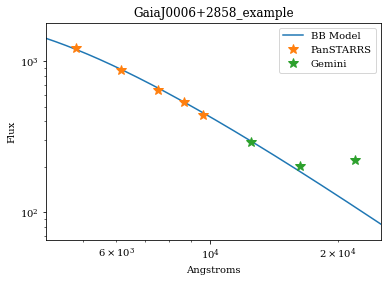

In [40]:
# Zero points & effective wavelengths for photometry points
F0_JHK=np.array([1530e6,1019e6,631e6])  # These are for UKIDSS JHK
wv_JHK=np.array([1.25*1e4,1.63*1e4,2.2*1e4])

# Converting photometry from magnitudes to flux in micro-Janksy
Flux_JHK,unFlux_JHK=FluxCal(Mag_JHK,unMag_JHK,F0_JHK)

# Calibrating optical photometry to flux units
F0_opt = 3631e6   # This is the AB mag system zero point
wv_opt = np.array([0.4810e4,0.6170e4,0.7520e4,0.8660e4,0.9620e4])
Flux_opt, unFlux_opt = FluxCal(Mag_opt,unMag_opt,F0_opt)

# Fitting a blackbody scaling factor to optical photometry:
scFit,scfit_err=curve_fit(ScalingFit,wv_opt,Flux_opt)

# Plotting SED with scaled WD BB model:
wvBBplot = np.arange(wv_opt[0]*0.85,wv_JHK[-1]*1.15,1)
fluxBBplot = BBFormula(wvBBplot,T,R,par)
plt.plot(wvBBplot,fluxBBplot*scFit,label = 'BB Model')
plt.yscale('log')
plt.xscale('log')
bottom,top = plt.ylim()
plt.plot(wv_opt,Flux_opt,'*',markersize = 10, label = 'PanSTARRS')
plt.plot(wv_JHK,Flux_JHK,'*',markersize = 10, label = 'Gemini')
plt.xlim(wvBBplot[0],wvBBplot[-1])
plt.ylim(bottom*0.9,top*1.1)
plt.title(target)
plt.ylabel('Flux')
plt.xlabel('Angstroms')
plt.legend()
plt.show()

In [51]:
# calculate a blackbody model for the WD
wvBB=np.arange(wv_corr[0]*0.9,wv_corr[-1]*1.1,1)  #Angstroms

fluxBB=BBFormula(wvBB,T,R,par)*scFit

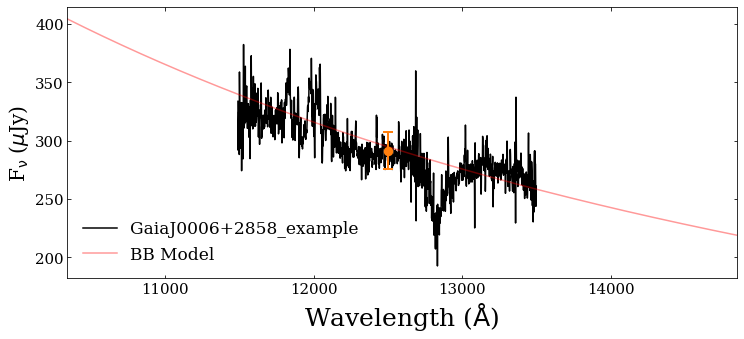

In [66]:
# Loading transmission filter of instrument used to observe photometry:
transfile = np.loadtxt('niri-J.txt')
wv_trans,flux_trans = transfile[:,0], transfile[:,1]  # Throughput axis must be decimal fractions (not %)!
flux_trans = flux_trans[np.argsort(wv_trans)] # Making sure wavelengths in transmission curve are in ascending order
wv_trans = np.sort(wv_trans)                  # (otherwise np.interp breaks)

# Calculating the calibration ratios for each band (they should be similar to each other)
ratio = SpecCal(wv_corr,flux_corr,wv_trans,flux_trans,Flux_JHK[0],False)

# Plotting calibrated spectrum with WD BB model
plt.figure(figsize = (12,5))
plt.plot(wv_corr,flux_corr*ratio,'k',label = target)
plt.errorbar(wv_JHK[0],Flux_JHK[0],yerr=unFlux_JHK[0],fmt='.',color='C1',markersize=15,capsize=5,elinewidth=2,markeredgewidth=2,zorder=50)
plt.plot(wvBB,fluxBB, color = 'r', alpha = 0.4,label = 'BB Model')

plt.tick_params(axis='both',which='major',labelsize=15,direction='in',right=True,top=True)
plt.tick_params(axis='both',which='minor',labelsize=15,direction='in',right=True,top=True)
plt.xlabel(r'Wavelength ($\mathrm{\AA}$)',fontsize=25)
plt.ylabel(r'F$_\mathrm{\nu}$ ($\mu$Jy)',fontsize=20)
plt.legend(fontsize=17,loc='lower left',frameon=False)
plt.xlim(wvBB[0],wvBB[-1])
plt.show()


In [65]:
# Output file name for calibrated spectrum:
outfile = 'GaiaJ0006+2858_example-calib.txt'

# Save calibrated spectrum:
SaveOutput(wv_corr,flux_corr*ratio,outfile)
